<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Finetuning-Pre-trained-BERT-Model-on-Text-Classification-Task-And-Inferencing-with-ONNX-Runtime" data-toc-modified-id="Finetuning-Pre-trained-BERT-Model-on-Text-Classification-Task-And-Inferencing-with-ONNX-Runtime-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Finetuning Pre-trained BERT Model on Text Classification Task And Inferencing with ONNX Runtime</a></span><ul class="toc-item"><li><span><a href="#Tokenizer" data-toc-modified-id="Tokenizer-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Tokenizer</a></span></li><li><span><a href="#Model-FineTuning" data-toc-modified-id="Model-FineTuning-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Model FineTuning</a></span></li><li><span><a href="#Onnx-Runtime" data-toc-modified-id="Onnx-Runtime-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Onnx Runtime</a></span></li></ul></li><li><span><a href="#Reference" data-toc-modified-id="Reference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', '..', 'notebook_format'))

from formats import load_style
load_style(css_style='custom2.css', plot_style=False)

In [2]:
# os.chdir(path)

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import os
import time
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from math import ceil
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from tqdm import trange
from contextlib import contextmanager
from torch.utils.data import DataLoader
from onnxruntime import InferenceSession, SessionOptions
from datasets import load_dataset, DatasetDict, Dataset, disable_progress_bar

# we prevent progress bar from flooding notebook console
disable_progress_bar()
os.environ["DISABLE_MLFLOW_INTEGRATION"] = "TRUE"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%watermark -a 'Ethen' -u -d -t -v -p datasets,transformers,torch,tokenizers,numpy,pandas,onnxruntime

Author: Ethen

Last updated: 2023-08-09 17:58:26

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 8.8.0

datasets    : 2.13.0
transformers: 4.31.0
torch       : 2.0.1
tokenizers  : 0.13.3
numpy       : 1.23.2
pandas      : 1.5.2
onnxruntime : 1.15.1



# Finetuning Pre-trained BERT Model on Text Classification Task And Inferencing with ONNX Runtime

Using a serialized format like ONNX (Open Neural Network Exchange) [[4]](https://onnx.ai/) for inferencing instead of vanilla PyTorch has several benefits, especially when deploying machine learning models to production or sharing them across different platforms. A couple of reasons includes:

- Hardware Acceleration and Optimization: ONNX supports hardware acceleration tailored to specific platforms as well as model specific optimizations such as quantization and compressions. i.e. If we have an application requiring high performance, ONNX can provide better lower latency, higher throughput, which also translates to lower cost.
- Deployment Compatibility and Flexibility: ONNX allows us to export our models from various frameworks into an unified representation. ONNX format models can then be directly loaded and used in a variety of programming languages (Python, C++, C#, etc.), making it easier to integrate into existing applications.

In this article, we'll be going over the process of converting a model into ONNX format, running inference with it, and performing benchmarks to see how it compares to vanilla PyTorch models.

## Data Preparation

We'll be using a BERT model fine-tuned towards Quora Question Pairs [[6]](https://www.kaggle.com/c/quora-question-pairs/data), a text classification task [[1]](https://nbviewer.org/github/huggingface/notebooks/blob/main/examples/text_classification.ipynb) to serve as our example.

In [3]:
dataset_dict = load_dataset("quora")
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['questions', 'is_duplicate'],
        num_rows: 404290
    })
})

In [4]:
dataset_dict['train'][0]

{'questions': {'id': [1, 2],
  'text': ['What is the step by step guide to invest in share market in india?',
   'What is the step by step guide to invest in share market?']},
 'is_duplicate': False}

In [5]:
test_size = 0.1
val_size = 0.1
dataset_dict_test = dataset_dict['train'].train_test_split(test_size=test_size)
dataset_dict_train_val = dataset_dict_test['train'].train_test_split(test_size=val_size)

dataset_dict = DatasetDict({
    "train": dataset_dict_train_val["train"],
    "val": dataset_dict_train_val["test"],
    "test": dataset_dict_test["test"]
})
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['questions', 'is_duplicate'],
        num_rows: 327474
    })
    val: Dataset({
        features: ['questions', 'is_duplicate'],
        num_rows: 36387
    })
    test: Dataset({
        features: ['questions', 'is_duplicate'],
        num_rows: 40429
    })
})

## Tokenizer

We won't be going over the details of the pre-trained tokenizer or model and only load one available from the huggingface model repository.

In [6]:
# https://huggingface.co/transformers/model_doc/distilbert.html
pretrained_model_name_or_path = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path)
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

We can feed our tokenizer directly with a pair of sentences.

In [7]:
encoded_input = tokenizer(
    "What is the step by step guide to invest in share market in india?",
    "What is the step by step guide to invest in share market?"
)
encoded_input

{'input_ids': [101, 2054, 2003, 1996, 3357, 2011, 3357, 5009, 2000, 15697, 1999, 3745, 3006, 1999, 2634, 1029, 102, 2054, 2003, 1996, 3357, 2011, 3357, 5009, 2000, 15697, 1999, 3745, 3006, 1029, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Decoding the tokenized inputs, this model's tokenizer adds some special tokens such as, `[SEP]`, that is used to indicate which token belongs to which segment/pair.

In [8]:
tokenizer.decode(encoded_input["input_ids"])

'[CLS] what is the step by step guide to invest in share market in india? [SEP] what is the step by step guide to invest in share market? [SEP]'

The proprocessing step will be task specific, if we happen to be using another dataset, this function needs to be modified accordingly.

In [9]:
def tokenize_fn(examples):
    labels = [int(label) for label in examples["is_duplicate"]]
    texts = [question["text"] for question in examples["questions"]]
    tokenized_examples = tokenizer(texts)
    tokenized_examples["labels"] = labels
    return tokenized_examples

In [10]:
dataset_dict_tokenized = dataset_dict.map(
    tokenize_fn,
    batched=True,
    num_proc=8,
    remove_columns=["is_duplicate", "questions"]
)
dataset_dict_tokenized

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 327474
    })
    val: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 36387
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 40429
    })
})

In [11]:
dataset_dict_tokenized["train"][0]

{'input_ids': [101,
  2054,
  2001,
  1996,
  7784,
  1997,
  1996,
  2645,
  1997,
  25158,
  1010,
  1998,
  2129,
  2106,
  2023,
  2645,
  12826,
  1998,
  5688,
  2000,
  1996,
  2645,
  1997,
  15544,
  25152,
  2232,
  1029,
  102,
  2054,
  2001,
  1996,
  7784,
  1997,
  1996,
  2645,
  1997,
  25158,
  1010,
  1998,
  2129,
  2106,
  2023,
  2645,
  12826,
  1998,
  5688,
  2000,
  1996,
  2645,
  1997,
  2605,
  1029,
  102],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'labels': 1}

## Model FineTuning

Having preprocessed our raw dataset, for our text classification task, we use `AutoModelForSequenceClassification` class to load the pre-trained model. The only other argument we need to specify is the number of class/label our text classification task has. Upon instantiating the model for the first time, we'll see some warnings generated, telling us we should fine tune this model on our down stream tasks before using it.

We'll also report standard binary classification evaluation metrics, including log loss, ROC-AUC, Average Precision (PR-AUC). As the focus is more around model inferencing, we only picked some default settings for training configuration.

In [12]:
def compute_metrics(eval_preds, round_digits: int = 3):
    y_pred, y_true = eval_preds
    y_score = y_pred[:, 1]

    log_loss = round(metrics.log_loss(y_true, y_score), round_digits)
    roc_auc = round(metrics.roc_auc_score(y_true, y_score), round_digits)
    pr_auc = round(metrics.average_precision_score(y_true, y_score), round_digits)
    return {
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'log_loss': log_loss
    }

In [13]:
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path, num_labels=2)
print('# of parameters: ', model.num_parameters())

data_collator = DataCollatorWithPadding(tokenizer, padding=True)

args = TrainingArguments(
    output_dir="quora_model_checkpoint",
    learning_rate=0.0001, # 2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=2,
    num_train_epochs=1,
    weight_decay=0.01,
    fp16=True,
    lr_scheduler_type="constant",
    evaluation_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=2,
    load_best_model_at_end=True
)

trainer = Trainer(
    model,
    args=args,
    data_collator=data_collator,
    train_dataset=dataset_dict_tokenized["train"],
    eval_dataset=dataset_dict_tokenized["val"],
    compute_metrics=compute_metrics
)
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# of parameters:  66955010


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Loss,Roc Auc,Pr Auc,Runtime,Samples Per Second,Steps Per Second
500,0.397300,1.217000,0.325360,0.930000,0.869000,10.278200,3540.225000,55.360000
1000,0.332200,1.481000,0.305294,0.938000,0.887000,10.259600,3546.636000,55.460000
1500,0.308400,1.176000,0.285987,0.947000,0.900000,10.261600,3545.953000,55.450000
2000,0.300900,1.260000,0.281945,0.948000,0.902000,10.226400,3558.136000,55.640000
2500,0.290300,0.924000,0.284556,0.951000,0.908000,10.243600,3552.179000,55.547000


TrainOutput(global_step=2558, training_loss=0.32501463781957796, metrics={'train_runtime': 319.8866, 'train_samples_per_second': 1023.719, 'train_steps_per_second': 7.997, 'total_flos': 6539402160476928.0, 'train_loss': 0.32501463781957796, 'epoch': 1.0})

In [14]:
# load from the best checkpoint
model = AutoModelForSequenceClassification.from_pretrained(trainer.state.best_model_checkpoint)
print('# of parameters: ', model.num_parameters())

# of parameters:  66955010


## Onnx Runtime

This section walks through the process of serializing our Pytorch model into ONNX format [[4]](https://onnx.ai/), and using ONNX runtime [[5]](https://www.onnxruntime.ai/) for model inferencing.

Exporting the model can be done via the `torch.onnx.export` function, which requires a model, sample input as well as some model specific configurations. Crucial parameters includes:

- Names of Input/Output: Instead of leaving these names blank, which would prompt the underlying engine to automatically generate them, explicitly specifying these names simplifies working with ONNX model during inference stage.
- dynamic_axes: While exporting our model, a sample input is needed to inform the underlying engine about what size and shape our serialized model should be expecting. In this example, we also specify our first, and second axis (corresponding to batch size and sequence length) as our `dynamic_axes`. By doing so, at inference time, ONNX won't be limited to the sample input size we've provided during this serialization process.

In [15]:
samples = dataset_dict['test'][:1]
texts = [question["text"] for question in samples["questions"]]
tokenized_texts = tokenizer(texts, padding=True)

input_ids = tokenized_texts["input_ids"]
attention_mask = tokenized_texts["attention_mask"]

input_ids_tensor = torch.LongTensor(input_ids).to(model.device)
attention_mask_tensor = torch.LongTensor(attention_mask).to(model.device)

In [16]:
opset_version = 15
onnx_model_path = "text_classification.onnx"

torch.onnx.export(
    model,
    (input_ids_tensor, attention_mask_tensor),
    onnx_model_path,
    opset_version=opset_version,
    input_names=["input_ids", "attention_mask"],
    output_names=["output"],
    dynamic_axes={
        "input_ids": {0: "batch_size", 1: "sequence_len"},
        "attention_mask": {0: "batch_size", 1: "sequence_len"},
        "output": {0: "batch_size"},
    }
)

/usr/local/lib/python3.8/dist-packages/transformers/models/distilbert/modeling_distilbert.py:223: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  mask, torch.tensor(torch.finfo(scores.dtype).min)


============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



The main entry point for using onnx runtime involves initiating the `InferenceSession` class, and passing our inputs via its `.run` method. Two things to note here:

- Upon performing a model serialization from vanilla PyTorch, it's generally a good practice to ensure output parity. i.e. model output from PyTorch is identical with the model output generated by onnx runtime.
- Once we export our model to ONNX, at run time, we technically no longer need PyTorch's associated dependencies, and only ONNX and ONNX runtime is required for inferencing.

In [17]:
def create_inference_session(
    model_path: str,
    intra_op_num_threads: int = 8,
    provider: str = 'CPUExecutionProvider'
) -> InferenceSession: 
    """
    Create onnx runtime InferenceSession.
    
    model_path : str
        onnx model file.
    
    intra_op_num_threads : int
        Remember to tune this parameter.
    
    provider : str
        get_all_providers function can list all available providers.
        e.g. CUDAExecutionProvider
    """

    options = SessionOptions()
    options.intra_op_num_threads = intra_op_num_threads

    # load the model as a onnx graph
    session = InferenceSession(model_path, options, providers=[provider])
    session.disable_fallback()
    return session

In [18]:
# pytorch inferencing
model.eval()
with torch.no_grad():
    torch_output = model(input_ids_tensor, attention_mask_tensor).logits.detach().cpu().numpy()


# onnx runtime inferencing
input_feed = {
    "input_ids": np.array(input_ids),
    "attention_mask": np.array(attention_mask)
}
session = create_inference_session(onnx_model_path, provider="CUDAExecutionProvider")
onnx_output = session.run(output_names=["output"], input_feed=input_feed)[0]

if np.allclose(torch_output, onnx_output, atol=1e-5):
    print("Exported model has been tested with ONNXRuntime, and the result looks good!")

print("input_ids: ", input_ids)
print("onnx output: ", onnx_output)

Exported model has been tested with ONNXRuntime, and the result looks good!
input_ids:  [[101, 2129, 2079, 1045, 3443, 1037, 2444, 11834, 11336, 2083, 9262, 22483, 1998, 1037, 4773, 4118, 1999, 1039, 1001, 1029, 102, 2129, 2064, 1045, 2079, 1037, 4773, 11834, 2083, 2026, 18059, 1029, 102]]
onnx output:  [[ 2.1795738 -3.1232638]]


2023-08-09 18:04:11.408286124 [W:onnxruntime:, session_state.cc:1169 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2023-08-09 18:04:11.408323399 [W:onnxruntime:, session_state.cc:1171 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


The next few section runs the benchmark on different batch sizes and inferencing options.

In [19]:
@contextmanager
def track_inference_time(buffer):
    start = time.perf_counter()
    yield
    end = time.perf_counter()
    elasped_time = (end - start)
    buffer.append(elasped_time)

In [20]:
class Benchmark:
    """
    Class to benchmark pytorch and onnx serialized models.
    Each benchmark* method runs the model for n_rounds and
    reports the average time it took to run inference.
    """

    def __init__(
        self,
        model_pytorch: nn.Module,
        model_onnx: InferenceSession,
        n_rounds = 50,
        n_warmup_rounds: int = 0
    ):
        self.model_pytorch = model_pytorch
        self.model_onnx = model_onnx
        self.n_rounds = n_rounds
        self.n_warmup_rounds = n_warmup_rounds

    def benchmark_pytorch(self, input_ids, attention_mask):
        """Expects the input_ids to be padded to the same sequence length."""
        device = self.model_pytorch.device
        input_ids_tensor = torch.LongTensor(input_ids).to(device)
        attention_mask_tensor = torch.LongTensor(attention_mask).to(device)
        
        for _ in range(self.n_warmup_rounds):
            self.model_pytorch(input_ids_tensor, attention_mask_tensor)

        time_buffer = []
        for _ in range(self.n_rounds):
            with track_inference_time(time_buffer):
                self.model_pytorch(input_ids_tensor, attention_mask_tensor).logits.detach().cpu().numpy()
        
        avg_elapsed_time = np.mean(time_buffer)
        return avg_elapsed_time
    
    def benchmark_onnx(self, input_ids, attention_mask):
        """Expects the input_ids to be padded to the same sequence length."""
        input_feed = {
            "input_ids": input_ids,
            "attention_mask": attention_mask
        }

        for _ in range(self.n_warmup_rounds):
            self.model_onnx.run(["output"], input_feed)[0]

        time_buffer = []
        for _ in range(self.n_rounds):
            with track_inference_time(time_buffer):
                onnx_output = self.model_onnx.run(["output"], input_feed)[0]

        avg_elapsed_time = np.mean(time_buffer)
        return avg_elapsed_time
    
    def benchmark_dynamic_onnx(self, input_ids, attention_mask):
        """
        Expects the input ids to be of dynamic size (i.e. non-padded).
        """
        input_feed = {
            "input_ids": input_ids,
            "attention_mask": attention_mask
        }
        for _ in range(self.n_warmup_rounds):
            self.model_onnx.run(["output"], input_feed)[0]

        time_buffer = []
        for _ in range(self.n_rounds):
            with track_inference_time(time_buffer):
                batch_onnx_output = []
                for input_id, mask in zip(input_ids, attention_mask):
                    input_feed = {"input_ids": [input_id], "attention_mask": [mask]}
                    onnx_output = self.model_onnx.run(["output"], input_feed)[0]
                    batch_onnx_output.append(onnx_output)

                outputs = np.concatenate(batch_onnx_output)

        avg_elapsed_time = np.mean(time_buffer)
        return avg_elapsed_time

In [21]:
# benchmark on GPU
model.eval()
model.to("cuda")
session = create_inference_session(onnx_model_path, provider="CUDAExecutionProvider")
benchmark = Benchmark(model, session, n_rounds=50)

batch_sizes = [1, 4, 8, 16, 32, 64]

# {model_option: [throughput number for each batch size]}
# e.g. {pytorch_gpu: [10.0, 12.0]}
batch_throughput_results = {}
for batch_size in batch_sizes:
    # tokenize & pad the raw text
    samples = dataset_dict["test"][:batch_size]
    texts = [question["text"] for question in samples["questions"]]
    tokenized_texts = tokenizer(texts, padding=True)

    input_ids = tokenized_texts["input_ids"]
    attention_mask = tokenized_texts["attention_mask"]

    pytorch_gpu_avg_elapsed_time = benchmark.benchmark_pytorch(input_ids, attention_mask)
    onnx_gpu_avg_elapsed_time = benchmark.benchmark_onnx(input_ids, attention_mask)

    throughput_results = {
        "pytorch_gpu": round(batch_size / pytorch_gpu_avg_elapsed_time, 2),
        "onnx_gpu": round(batch_size / onnx_gpu_avg_elapsed_time, 2)
    }

    for model_option, throughput in throughput_results.items():
        if model_option in batch_throughput_results:
            batch_throughput_results[model_option].append(throughput)
        else:
            batch_throughput_results[model_option] = [throughput]

batch_throughput_results

2023-08-09 18:04:12.261978119 [W:onnxruntime:, session_state.cc:1169 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2023-08-09 18:04:12.262011382 [W:onnxruntime:, session_state.cc:1171 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


{'pytorch_gpu': [125.28, 461.8, 953.71, 1585.61, 1726.07, 1821.52],
 'onnx_gpu': [491.18, 1504.06, 1438.97, 1623.95, 1768.59, 1813.98]}

In [22]:
def plot_throughput(batch_throughput_results, batch_sizes):
    fig = plt.figure(figsize=(10, 5))

    bar_width = 0.3
    br_list = np.arange(len(batch_sizes))
    for i, (model_name, throughput_list) in enumerate(batch_throughput_results.items()):
        br = br_list + (i * bar_width)
        plt.bar(br, throughput_list, width=bar_width, label=model_name)

    i = ceil(len(batch_throughput_results) / 2)
    ticks = br_list + i * bar_width / 2
    plt.xticks(ticks, batch_sizes)
    plt.xlabel("Batch Size")
    plt.ylabel("Throughput (samples/s)")
    plt.title("Model Throughput Comparison")
    plt.legend(fontsize=8, loc="upper left")
    plt.show()

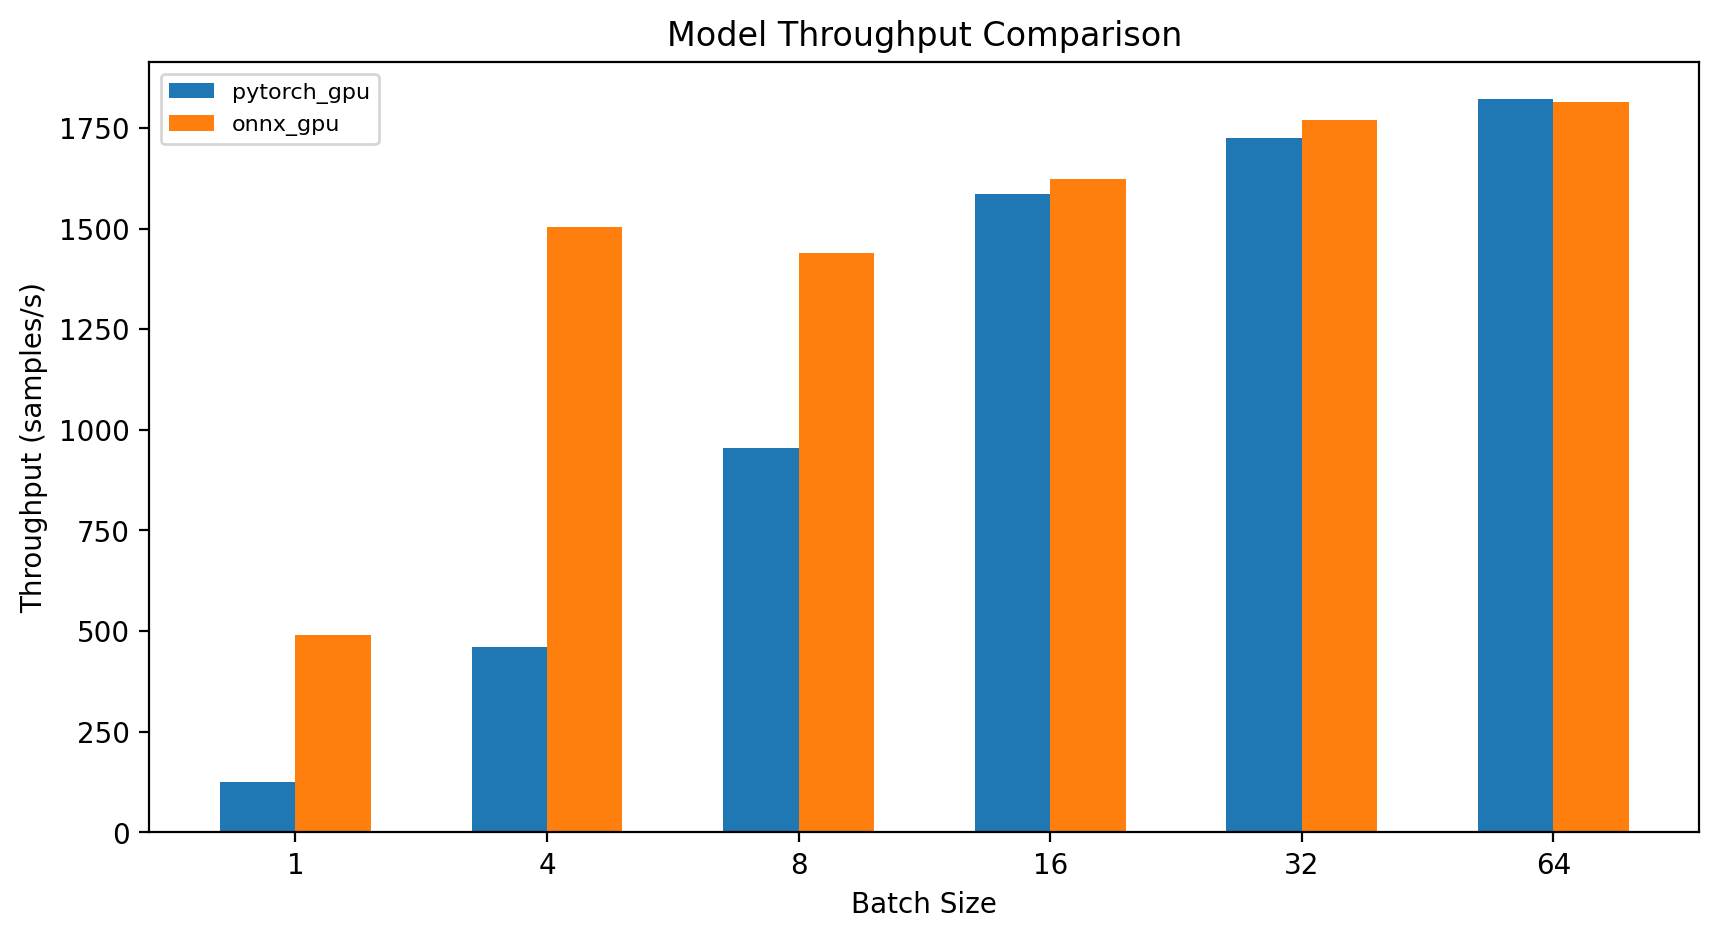

In [23]:
plot_throughput(batch_throughput_results, batch_sizes)

In [24]:
# benchmark on CPU
model.eval()
model.to("cpu")
session = create_inference_session(
    onnx_model_path,
    intra_op_num_threads=8,
    provider="CPUExecutionProvider"
)
benchmark = Benchmark(model, session, n_rounds=50)

batch_sizes = [1, 4, 8, 16]

# {model_option: [throughput number for each batch size]}
# e.g. {pytorch_cpu: [10.0, 12.0]}
batch_throughput_results = {}
for batch_size in batch_sizes:
    # tokenize & pad the raw text
    samples = dataset_dict['test'][:batch_size]
    texts = [question["text"] for question in samples["questions"]]
    tokenized_texts = tokenizer(texts, padding=True)
    input_ids = tokenized_texts["input_ids"]
    attention_mask = tokenized_texts["attention_mask"]

    pytorch_cpu_avg_elapsed_time = benchmark.benchmark_pytorch(input_ids, attention_mask)
    onnx_cpu_avg_elapsed_time = benchmark.benchmark_onnx(input_ids, attention_mask)
    
    tokenized_texts = tokenizer(texts)
    input_ids = tokenized_texts["input_ids"]
    attention_mask = tokenized_texts["attention_mask"]
    dynamic_onnx_cpu_avg_elapsed_time = benchmark.benchmark_dynamic_onnx(input_ids, attention_mask)

    throughput_results = {
        "pytorch_cpu": round(batch_size / pytorch_cpu_avg_elapsed_time, 2),
        "onnx_cpu": round(batch_size / onnx_cpu_avg_elapsed_time, 2),
        "dynamic_onnx_cpu": round(batch_size / dynamic_onnx_cpu_avg_elapsed_time, 2)
    }

    for model_option, throughput in throughput_results.items():
        if model_option in batch_throughput_results:
            batch_throughput_results[model_option].append(throughput)
        else:
            batch_throughput_results[model_option] = [throughput]

batch_throughput_results

{'pytorch_cpu': [40.2, 52.56, 34.25, 38.65],
 'onnx_cpu': [55.48, 64.06, 35.37, 36.33],
 'dynamic_onnx_cpu': [56.36, 53.95, 40.64, 55.6]}

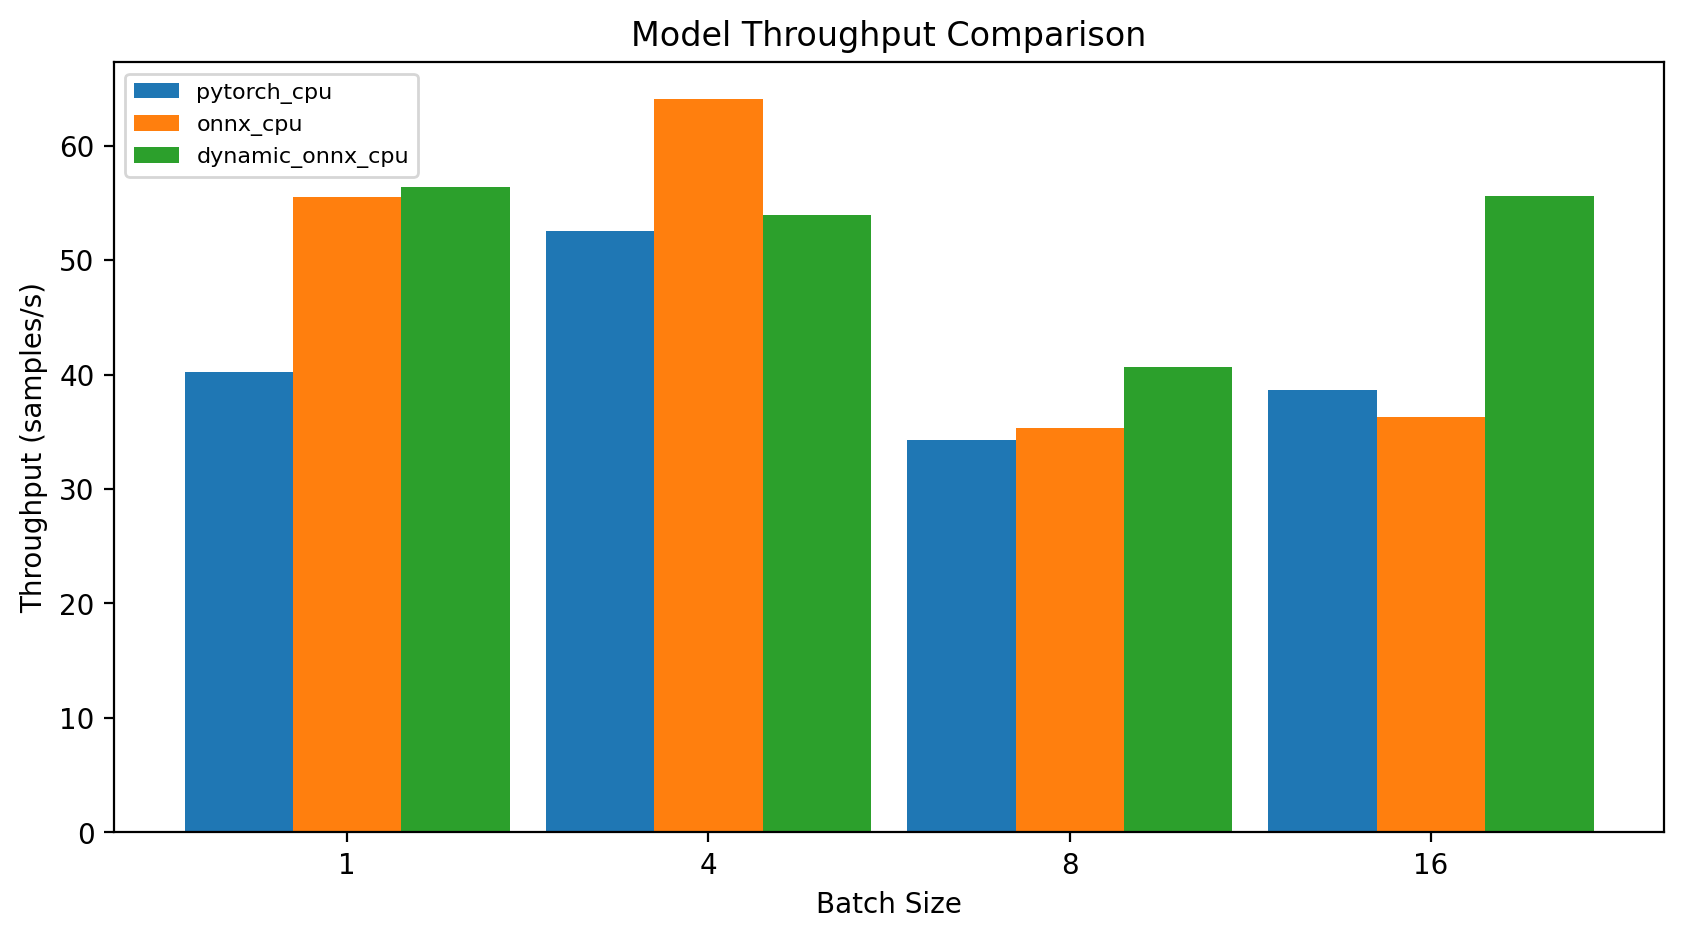

In [25]:
plot_throughput(batch_throughput_results, batch_sizes)

A couple of observations from the benchmark table and graph above.

- For GPU inferencing, on small batch sizes, we see a signficant throughput improvement via ONNX. e.g. for a batch size of 4, we're seeing 3x improvements. Though this improvement diminishes as batch size grows larger. - GPU benchmark number was ran on a single V100 GPU, it will be best to run these numbers on the targeted machine we'll be using to perform these inferencing.
- For CPU inferencing, a similar trend can be observed. With one important difference being: A common practice in GPU settings is to work with batched and padded data. i.e. Each batch of data are all padded to a fixed sequence length. Doing this degrades the performance for CPU inferencing, which has a lot less parallelism in place compared to GPU. Hence when conducting inferencing on a CPU, for larger batch size, it can be beneficial to perform dynamic sequence length inferencing, with one example at a time.

We've only scratched the surface on what's possible in terms of speeding up our models for inferencing. There're additional techniques such as quantization [[3]](https://medium.com/microsoftazure/faster-and-smaller-quantized-nlp-with-hugging-face-and-onnx-runtime-ec5525473bb7) [[7]](https://cloudblogs.microsoft.com/opensource/2022/04/19/scaling-up-pytorch-inference-serving-billions-of-daily-nlp-inferences-with-onnx-runtime/) and compression that we haven't covered. And in terms of model serialization, there're also various tools out there, with ONNX + ONNX runtime being just one of them. But hopefully, this introduction helps build an understanding that for model deployment, there's an additional model serialization step that is commonly used to optimize inference efficiency as well as development experience.

# Reference

- [[1]](https://nbviewer.org/github/huggingface/notebooks/blob/main/examples/text_classification.ipynb) Jupyter Notebook: Fine-tuning a model on a text classification task
- [[2]](https://nbviewer.org/github/huggingface/notebooks/blob/main/examples/onnx-export.ipynb) Jupyter Notebook: Exporting transformers model to ONNX
- [[3]](https://medium.com/microsoftazure/faster-and-smaller-quantized-nlp-with-hugging-face-and-onnx-runtime-ec5525473bb7) Blog: Faster and smaller quantized NLP with Hugging Face and ONNX Runtime
- [[4]](https://onnx.ai/) ONNX
- [[5]](https://www.onnxruntime.ai/) ONNX runtime
- [[6]](https://www.kaggle.com/c/quora-question-pairs/data) Kaggle: Quora Question Pairs
- [[7]](https://cloudblogs.microsoft.com/opensource/2022/04/19/scaling-up-pytorch-inference-serving-billions-of-daily-nlp-inferences-with-onnx-runtime/) Scaling-up PyTorch inference: Serving billions of daily NLP inferences with ONNX Runtime